In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
import corner

from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import Distance

from mockFRBhosts import generate_frbs, plot_population, draw_galaxies, observed_bands, draw_DM, observing_time
from mockFRBhosts.mcmc_simulations import do_mcmc

In [2]:
# Generate an FRB population
# Specify telescope and parameters
survey_model, beam_model = 'askap-incoh', 'gaussian'
z_model, z_max, bol_lum_low = 'sfr', 1.2, 1e42

# Convert the upper energy limit into a luminosity limit.
energy_high = 10**41.88  # James et al. 2022 with alpha as rate but with uniform prior
specif_lum_high = energy_high/(1e9*0.00267)  # 1GHz bandwidth 2.67ms burst width

# Generate a cosmic and observed population.
cosmic_pop, survey_pop = generate_frbs(survey_model, beam_model, z_model=z_model, n_srcs=1e6, z_max=z_max, 
                                       bol_lum_low=bol_lum_low, specif_lum_high=specif_lum_high)

# Convert it into a pandas data frame.
frbs = survey_pop.to_df()
n_frbs = len(frbs)
print(n_frbs, "FRBs were observed")

cosmic_pop.py | Generating cosmic population
cosmic_pop.py | Finished generating cosmic population
survey_pop.py | Surveying cosmic with askap-incoh
316 FRBs were observed


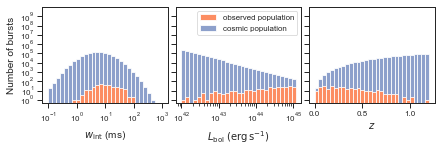

In [3]:
# Compare the observed with the cosmic population.
fig = plot_population(frbs, cosmic_pop, cpop_factor=1, plot_james=False)
fig.show()

In [4]:
# Draw a host galaxy for every FRB. Weight by the star formation rate.
galaxies, snapnum = draw_galaxies(frbs['z'], weights='mstardot', seed=42, gal_files=None)

# Order FRBs such that they correspond to galaxies at the same positions.
frbs.loc[:, 'snapnum'] = snapnum
frbs.sort_values('snapnum', ascending=True, inplace=True)

# See how many galaxies are observed in how many bands of the 4 optical surveys.
n_bands_obs_SDSS, n_bands_obs_LSST, n_bands_obs_Euclid, n_bands_obs_DES = observed_bands(frbs, galaxies)

Distance model: sfr, no host: 8.2%, all bands: 84.8%


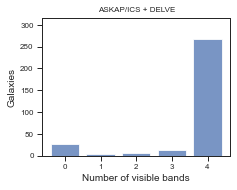

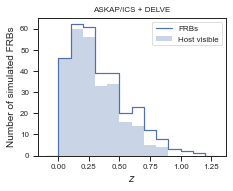

In [5]:
# Plot the number of observed bands and the redshift distribution for one survey.
columnwidth = 3.37574803
fig, ax = plt.subplots(figsize=(columnwidth, columnwidth/6.4*4.8))
n_bands_obs = n_bands_obs_DES
n_bands = n_bands_obs_DES.max()

bins = np.linspace(-.5, n_bands+.5, n_bands+2)
sns.histplot(x=n_bands_obs, bins=bins, fill=True, shrink=.8, )

# Name axes etc.
ax.set_xlabel('Number of visible bands')
ax.set_ylabel('Galaxies')
ax.set_xticks(range(0, n_bands+1))
ax.set_ylim(0, n_frbs)
ax.set_title("ASKAP/ICS + DELVE")
#ax.legend()

# Print the basic stats
n_band_hist = np.histogram(n_bands_obs, bins)[0]
print(f"Distance model: {z_model}, no host: {n_band_hist[0]/n_frbs:.1%}, all bands: {n_band_hist[-1]/n_frbs:.1%}")


fig, ax = plt.subplots(figsize=(columnwidth, columnwidth/6.4*4.8))

# Fix bin width. Put one extra bin on each side to draw the line back to the bottom.
binwidth = 0.1
bins = np.arange(0-binwidth, z_max+2*binwidth, binwidth)

sns.histplot(data=frbs.iloc[::-1], x='z', bins=bins, element='step', fill=False, legend=True, 
             ax=ax, label="FRBs")
sns.histplot(data=frbs.loc[n_bands_obs.to_numpy() == n_bands].iloc[::-1].reindex(), 
             x='z', bins=bins, element='step', alpha=.3,
             linewidth=0, legend=True, ax=ax, label="Host visible")

ax.set_xlabel('$z$')
ax.set_ylabel('Number of simulated FRBs')
ax.set_title("ASKAP/ICS + DELVE")
ax.legend()

In [6]:
# Draw a DM for each FRB given its reshift.
rng = np.random.default_rng(seed=42)
frbs['DM'] = draw_DM(frbs['z'], F=0.2, mu=100, lognorm_s=1, rng=rng)

In [7]:
# Get apparent magnitudes in SDSS to calculate the observing time
frb_zs = frbs['z'].to_numpy()
dist = Distance(z=frb_zs, cosmology=cosmo)
apparent_mag = (dist.distmod.value[:, np.newaxis] + 5*np.log10(cosmo.h)
                    - 2.5*np.log10(1+frb_zs)[:, np.newaxis]
                    + galaxies.loc[:, 'mag_SDSS-u_tot':'mag_SDSS-z_tot'])

In [8]:
# Calculate the Galaxy size assuming a size of 4 arcsec^2 at 1 Gpc distance, which is around 10 kpc diameter.
gal_size = 4 * (1*u.Gpc/cosmo.angular_diameter_distance(frb_zs)).decompose()**2

# Calculate the observing time needed to see a galaxy in one band with a 10m telescope.
obs_time = observing_time(apparent_mag['mag_SDSS-r_tot'], snr=10, gal_size=gal_size)

# Save it and make different arrays with visible glaxies etc.
frbs['obs_time'] = obs_time.to_numpy()

frbs_wo_host = frbs[n_bands_obs.to_numpy() == 0].sort_values('z', ascending=True)
frb_in_some_band = frbs[(n_bands_obs < n_bands).to_numpy() & (n_bands_obs > 0).to_numpy()].sort_values('z', ascending=True)

obs_time = frbs['obs_time']
obs_time_wo_host = frbs_wo_host['obs_time']
obs_time_isb = frb_in_some_band['obs_time']

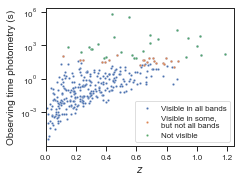

In [9]:
# Plot photometric time vs. z
fig, ax = plt.subplots(figsize=(columnwidth, columnwidth*4.8/6.4))
sns.scatterplot(x=frbs['z'], y=obs_time, ax=ax, label="Visible in all bands", s=5)
sns.scatterplot(x=frb_in_some_band['z'], y=obs_time_isb, ax=ax, label="Visible in some,\nbut not all bands", s=5)
sns.scatterplot(x=frbs_wo_host['z'], y=obs_time_wo_host, ax=ax, label="Not visible", s=5)

ax.set_xlim(0, None)
ax.set_yscale('log')
ax.set_xlabel("$z$")
ax.set_ylabel("Observing time photometry (s)")
ax.legend(loc='lower right')
ax.set_yticks([10**n for n in range(-3, 8, 3)])

plt.show()

In [10]:
# Make a small MCMC simulation for a few FRBs that have a host galaxy. Should take about 2 min.
draws = 1000  # Draws are per chain.
cores = 8    # Number of available CPU cores. Each core has its own chain.

frbs_w_host = frbs[n_bands_obs.to_numpy() == n_bands]
frb_set = frbs_w_host.iloc[:20]  # Use only a few to keep it short.

idata = do_mcmc(frb_set['z'], frb_set['DM'], draws=draws, cores=cores, tune=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Slice: [lognorm_s]
>Slice: [mu]
>Slice: [F]
>Slice: [Obh70]
Sampling 8 chains for 100 tune and 1_000 draw iterations (800 + 8_000 draws total) took 107 seconds.
The number of effective samples is smaller than 25% for some parameters.


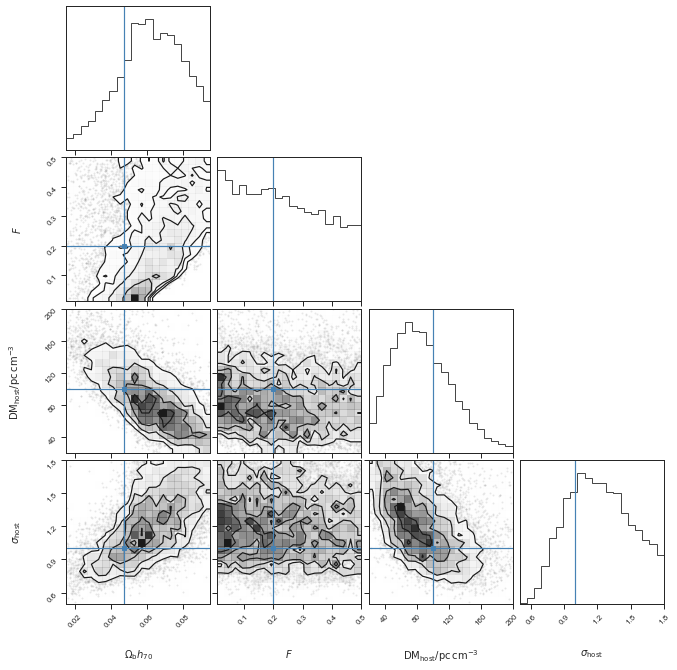

In [11]:
# Set fiducial parameters for comparison
Obh70, F, mu, lognorm_s = cosmo.Ob0*cosmo.H0.value/70, .2, 100, 1

# Plot the results of the MCMC simulation.
fig = corner.corner(idata, color='k', 
                    var_names=['Obh70', 'F', 'mu', 'lognorm_s'], 
                    labels=['$\Omega_\mathrm{b} h_{70}$', '$F$', r'$\mathrm{DM}_\mathrm{host}/\mathrm{pc}\,\mathrm{cm}^{-3}$', '$\sigma_\mathrm{host}$'],
                    range=[(0.015, 0.095), (0.011, .5), (20, 200), (0.5, 1.8)],
                    truths=[Obh70, F, mu, lognorm_s])